# List of Imported Python Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import numpy as np
from scipy.fftpack import fft, fftfreq #for seasonality removal
from scipy import stats
import matplotlib.pylab as plt
import ruptures as rpt #for CPD algorithm

# Importing Entire Data Set and Transforming

In [5]:
data_df = pd.read_csv('***.csv')

In [3]:
data_df = data_df.rename({'Year Week': 'yearweek', 'IRI Style': 'iri_style', 'Unit Sales Baseline Calc': 'unit_sales'}, axis=1)
data_df['unit_sales']=data_df['unit_sales']*A # A is a coefficient that the data is multipled in order to keep confidentiality of data.
uniques = len(data_df['iri_style'].unique())

/data/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


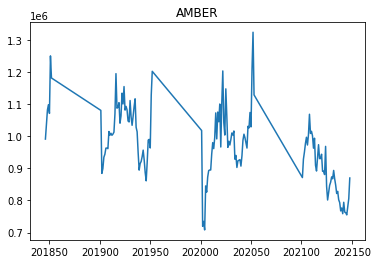

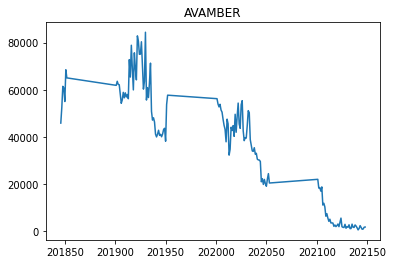

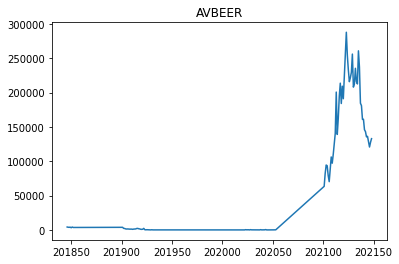

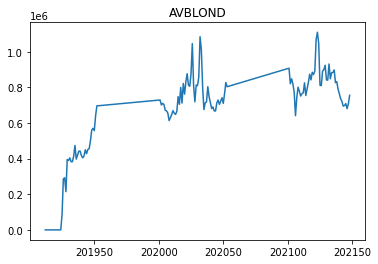

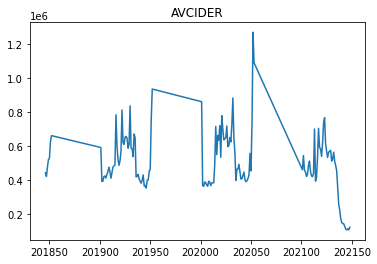

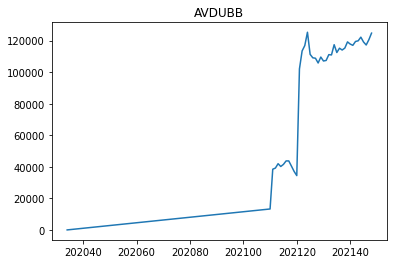

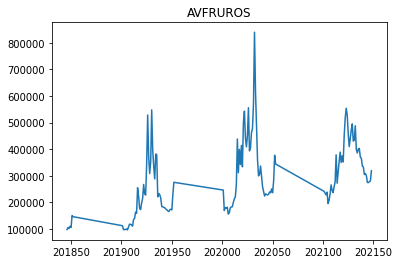

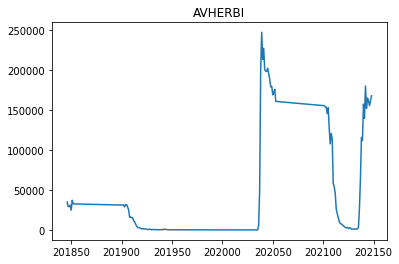

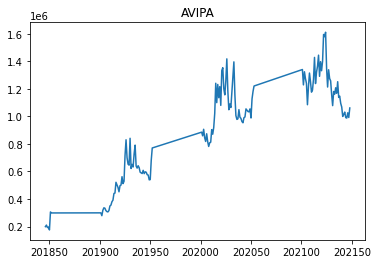

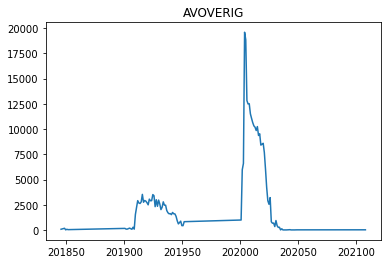

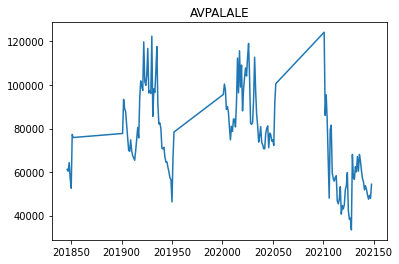

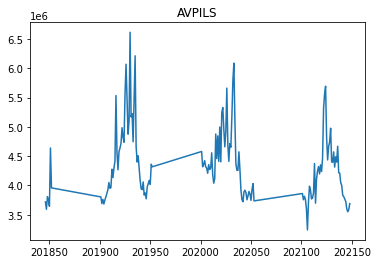

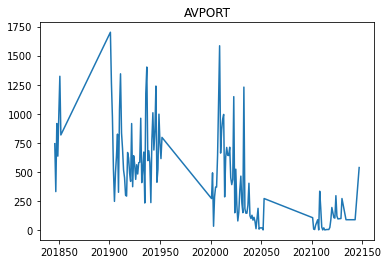

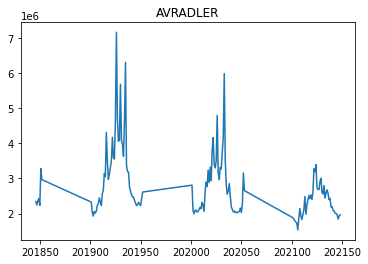

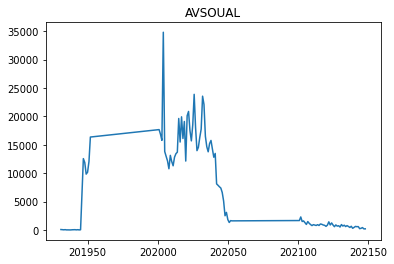

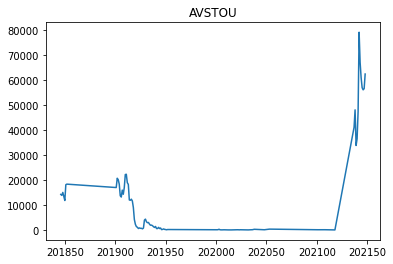

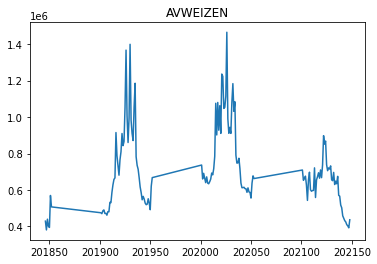

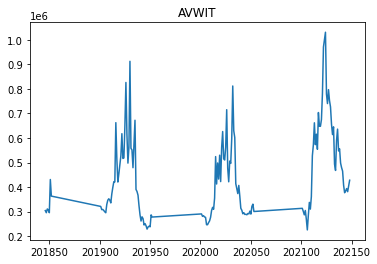

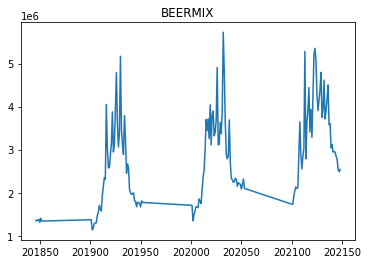

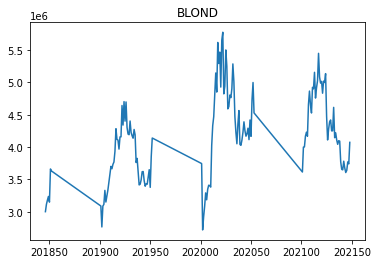

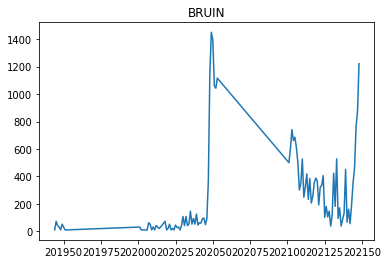

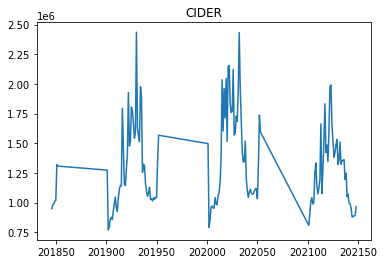

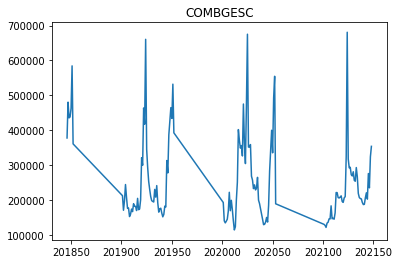

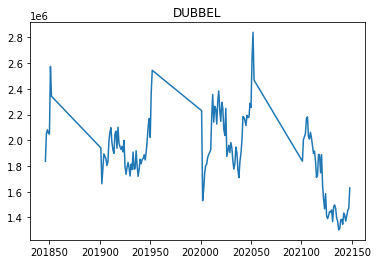

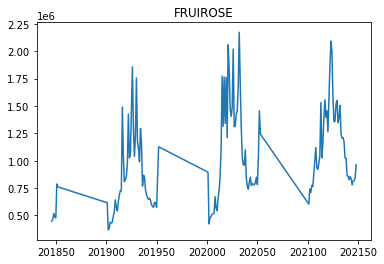

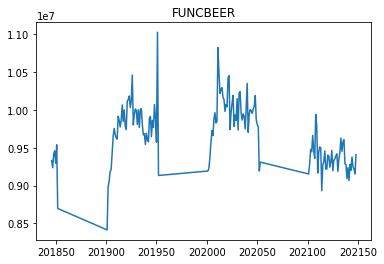

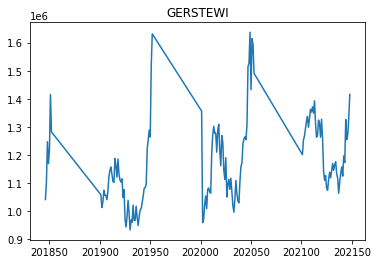

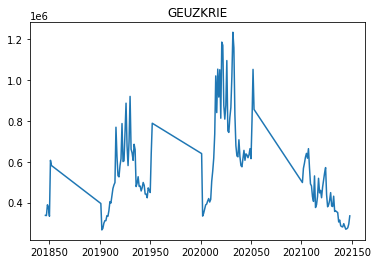

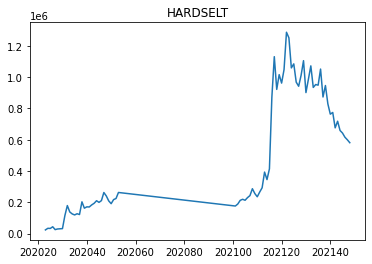

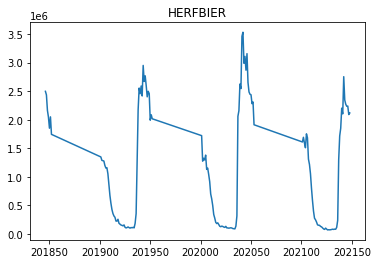

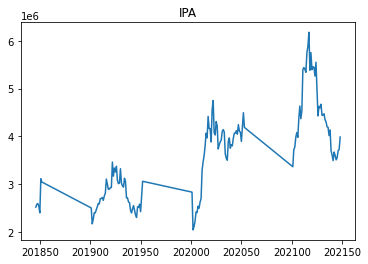

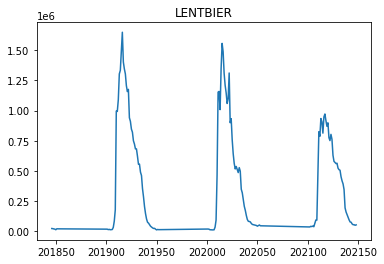

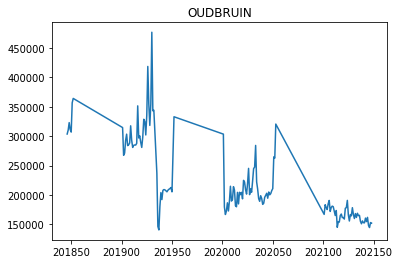

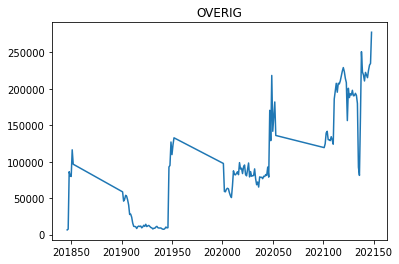

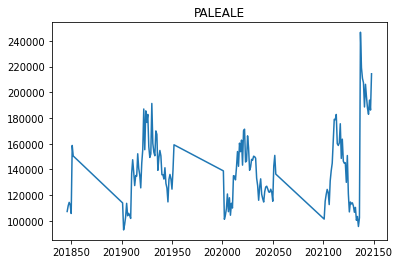

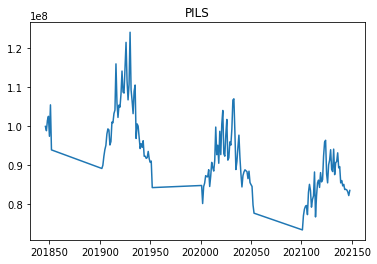

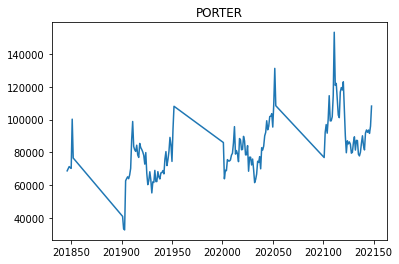

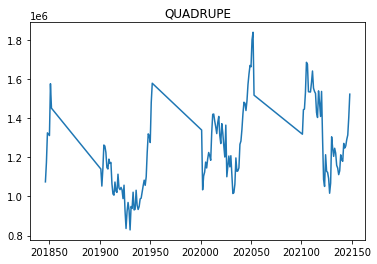

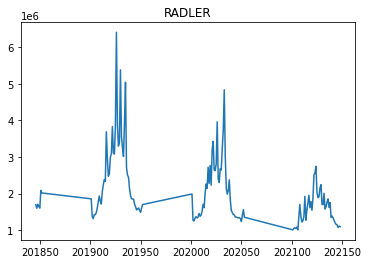

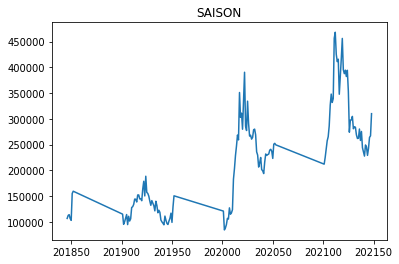

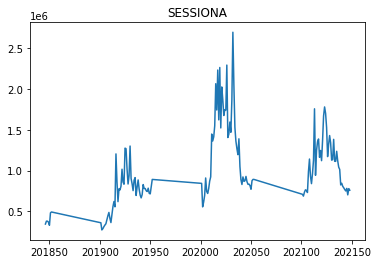

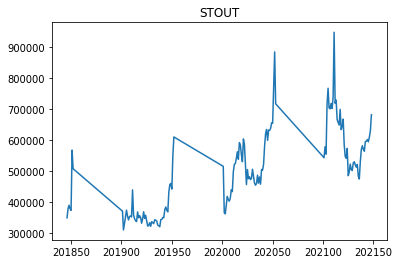

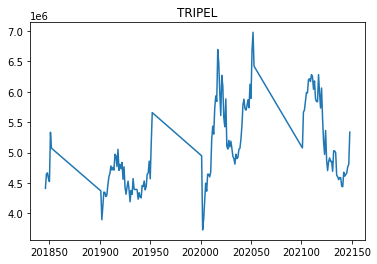

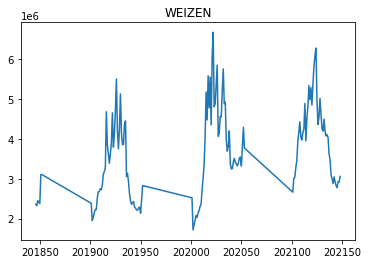

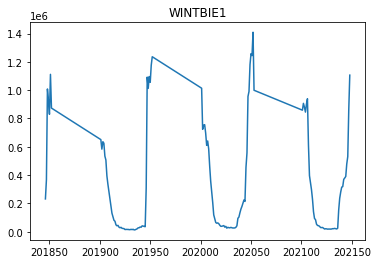

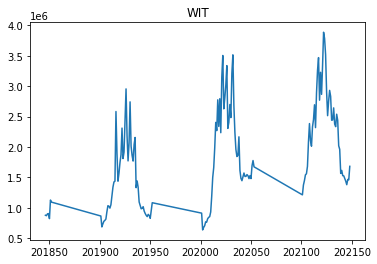

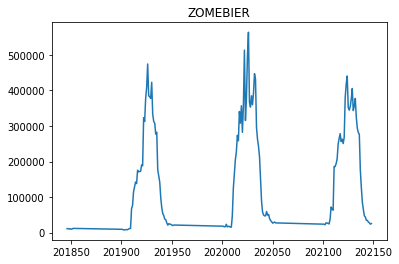

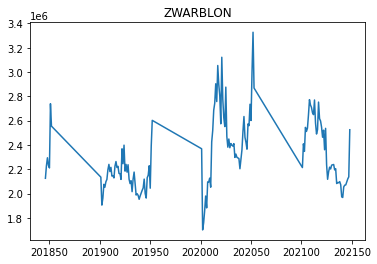

In [5]:
for style, data in data_df.groupby('iri_style'):
    plt.figure()
    plt.plot(data.yearweek, data.unit_sales)
    plt.title(style)


# Selecting Style to be Analyzed 

my_data = data_df[data_df.iri_style == 'AVBLOND']

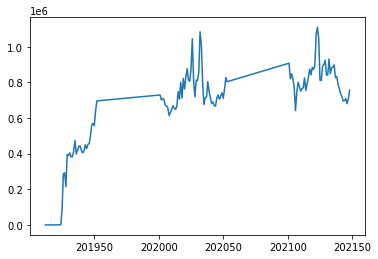

In [7]:
plt.plot(my_data.yearweek, my_data.unit_sales)

# Pre-processing Step 1: Removing Seasonality

In [8]:
# https://medium.com/@himsmittal/finding-seasonality-74a4046e6e23

# get top 3 seasons
no_of_seasons=3
series = np.asarray(my_data.unit_sales)

# Compute FFT
series_fft = fft(series)

# Compute the power (amplitude spectrum)
power = np.abs(series_fft)

# Get the corresponding frequencies
sample_freq = fftfreq(series_fft.size)

# Find the peak frequency: we only need the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
powers = power[pos_mask]

# find top frequencies and corresponding time periods for seasonal pattern
top_powers = np.argpartition(powers, -no_of_seasons)[-no_of_seasons:]

time_periods_from_fft = 1 / freqs[top_powers]
time_periods = time_periods_from_fft.astype(int)

print(f"Potential periods for seasonality {time_periods}")

Potential periods for seasonality [ 45  67 135]


In [9]:
# One of the seasonality returned from FFT should be within range of Expected time period
for time_lag in time_periods:
    # Check ACF value with lags identified from FFT.
    acf_score = acf(series, nlags=time_lag)[-1]

    # Check ACF is significant or not.
    if acf_score >= 2 / np.sqrt(len(series)):
        # ACF is significant and FFT identifies seasonality
        print(f'ACF is significant for {time_lag}')
    else:
        print(f'ACF is not significant for {time_lag}')

ACF is not significant for 45
ACF is not significant for 67
ACF is not significant for 135


/home/nur_vf/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [ ]:
# Apply seasonality decomposition

In [10]:
x_processed = my_data.unit_sales
x_processed.index = my_data.yearweek #if no seasonality detected

In [ ]:
#Decomposition - if seasonality detected
decomposition = seasonal_decompose(x, period=53) # Enter detected seasonality as period manually
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
plt.show()
yhat_add = (seasonal.fillna(0) + trend.fillna(0)  + residual.fillna(0))
yhat_add.plot()
x.plot()
x_processed = x - seasonal

<AxesSubplot:xlabel='yearweek'>

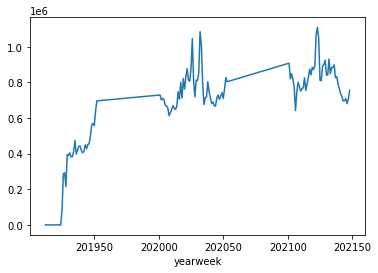

In [11]:
x_processed.plot()

# Pre-processing Step 2: Smoothing Outliers

In [19]:
x_smoothed =x_processed.rolling(13, center=True, min_periods=1).mean() # Enter period manually. Current is 13 week window, can be adjusted to 4

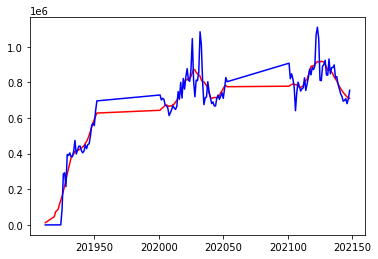

In [20]:
plt.plot(x_smoothed.index, x_smoothed.values, 'r')
plt.plot(x_processed.index, x_processed.values, 'b')

yearweek
201912     12382.500000
201919     46653.600000
201920     73973.977778
201922     88044.197500
201923    115958.410909
              ...      
202144    735492.020455
202145    725807.015500
202146    718643.772778
202147    712921.479375
202148    709629.115000
Name: unit_sales, Length: 135, dtype: float64

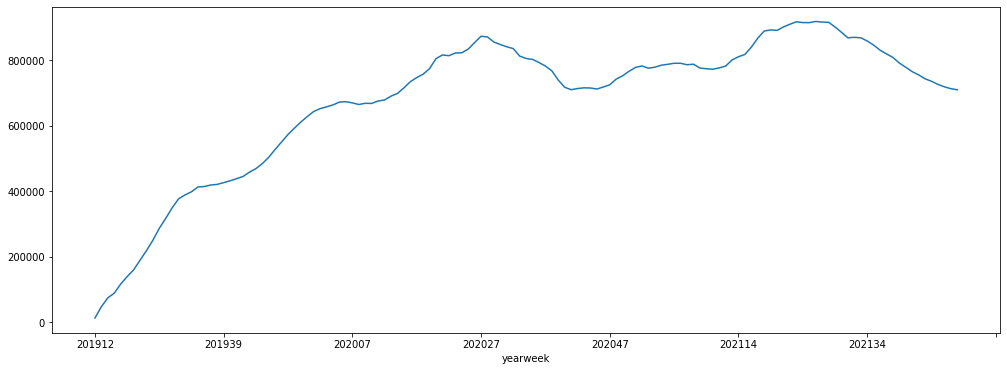

In [23]:
x_smoothed.index=x_smoothed.index.astype(str)
x_smoothed.plot(figsize=(17, 6))

# Change Point Detection: Bottom-Up Segmentation

Bottom-up change point detection is used to perform fast signal segmentation and is implemented in ruptures.detection.BottomUp. It is a sequential approach. Contrary to binary segmentation, which is a greedy procedure, bottom-up segmentation is generous: it starts with many change points and successively deletes the less significant ones. First, the signal is divided in many sub-signals along a regular grid. Then contiguous segments are successively merged according to a measure of how similar they are. It can extend any single change point detection method to detect multiple changes points and that it can work whether the number of regimes is known beforehand or not.

In [152]:
# Setting Parameters
sigma = np.std(x_smoothed.values)
penalty_value = np.log(160)*1*sigma**2
model = "l2"  # "other options: l1", "rbf", "linear", "normal", "ar",...

penalty value:  231380110600.8699


In [57]:
# change point detection

algo = rpt.BottomUp(model=model).fit(x_smoothed.values[3:-1])
bu_changepoints = algo.predict(pen=penalty_value)

/data/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(-20.0, 0, '201912'),
 Text(0.0, 0, '201919'),
 Text(20.0, 0, '201920'),
 Text(40.0, 0, '201922'),
 Text(60.0, 0, '201923'),
 Text(80.0, 0, '201924'),
 Text(100.0, 0, '201925'),
 Text(120.0, 0, '201926'),
 Text(140.0, 0, '201927'),
 Text(160.0, 0, '201928')]

<Figure size 432x288 with 0 Axes>

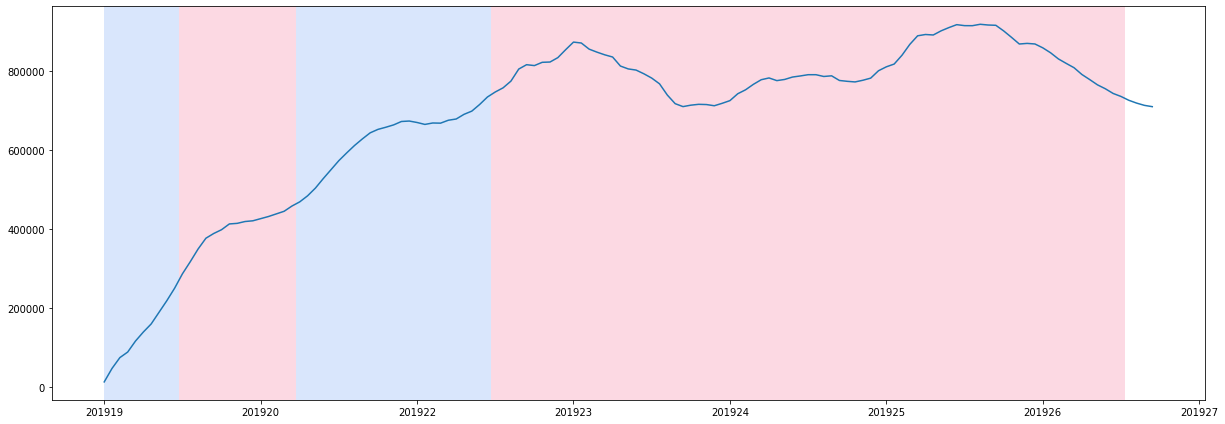

In [59]:
#Plotting results
fig = plt.figure()
a = rpt.show.display(x_smoothed.values, bu_changepoints, figsize=(17, 6))

labels = ['0']
for i in range(0, len(x_smoothed), 20):
    labels.append(x_smoothed.index[i])
    
a[1][0].set_xticklabels(labels)

In [60]:
#Detected Change Points
cp=x_smoothed.loc[x_smoothed.index[bu_changepoints[:-1]]]
cp

yearweek
201929    286250.020000
201944    468520.424615
202017    746844.239615
Name: unit_sales, dtype: float64

# Labelling Stages

In [46]:
#Creating dataframes for stages and log transforming for slope calculation
stage1=np.log(x_smoothed.loc[:cp.index[0]])
stage2=np.log(x_smoothed.loc['201930':cp.index[1]]) # Dates are entered manually based on output of previous stage
stage3=np.log(x_smoothed.loc['201945':cp.index[2]])
stage4=np.log(x_smoothed.loc['202018':])

slope: 0.19,p-value: 0.0000


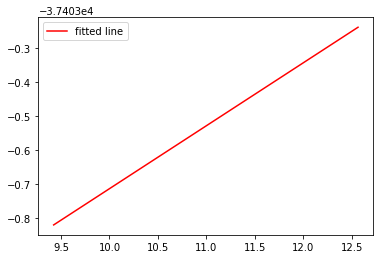

In [60]:
slope, intercept, r_value, p_value, std_err = stats.linregress(stage1.index, stage1.values)
print(f"slope: {slope:.2f},p-value: {p_value:.4f}")

plt.plot(stage1, intercept + slope*stage1, 'r', label='fitted line')
plt.legend()
plt.show()

slope: 0.02, p-value: 0.0000


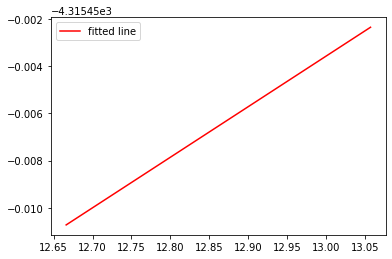

In [61]:
slope, intercept, r_value, p_value, std_err = stats.linregress(stage2.index, stage2.values)
print(f"slope: {slope:.2f}, p-value: {p_value:.4f}")
plt.plot(stage2, intercept + slope*stage2, 'r', label='fitted line')
plt.legend()
plt.show()

slope: 0.00,p-value: 0.0000


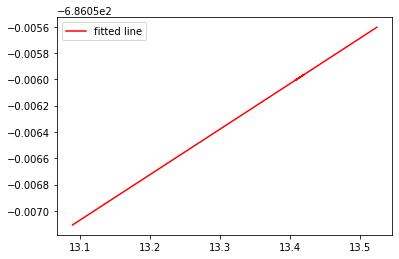

In [62]:
slope, intercept, r_value, p_value, std_err = stats.linregress(stage3.index, stage3.values)
print(f"slope: {slope:.2f},p-value: {p_value:.4f}")
plt.plot(stage3, intercept + slope*stage3, 'r', label='fitted line')
plt.legend()
plt.show()

slope: 0.00,p-value: 0.0488


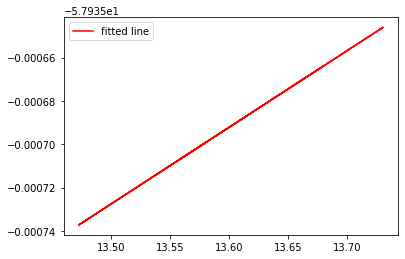

In [63]:
slope, intercept, r_value, p_value, std_err = stats.linregress(stage4.index, stage4.values)
print(f"slope: {slope:.2f},p-value: {p_value:.4f}")
plt.plot(stage4, intercept + slope*stage4, 'r', label='fitted line')
plt.legend()
plt.show()

Note. The labeling is still manual based on calculated slopes and decided criteria. During implementation this process should be automated using if statements. Criteria:

•	Introduction: The slope is not significant (p > 0.05) and the starting point is 0 unit of sales.  
•	Growth: The slope is positive and significant (p < 0.05).  
•	Maturity: The slope is not significant (p > 0.05) and the starting point is not 0 unit of sales.  
•	Decline: The slope is negative and significant (p < 0.05).  
•	Rapid Decline or Growth: The absolute value of log transformed slope is larger than 0. 

